We first try to figure out which is the best SVM classifier between Linear, 2nd degree polynomial, radial basis function and their angularised versions, each tested with different hyperparameter configurations. To achieve kernel angularisation, we did not change the standard kernel functions, but angularised the data.

In [1]:
import numpy as np
from svm_classifier import best_hyperparameter_svm, best_hyperparameter_angular_svm
from knn_classifier import k_nn
from time import time
import pandas as pd
from ctypes import cdll, c_float, Structure
from math import sqrt as sqrt
from sys import float_info
from platform import processor


if "x86" in processor():
    from sklearnex import patch_sklearn

    patch_sklearn()

lib = cdll.LoadLibrary("./lib_naive_.so")


class cross_validation_result(Structure):
    _fields_ = [    ("avg_accuracy", c_float),
                    ("min_accuracy", c_float),
                    ("max_accuracy", c_float),
                    ("accuracy_variance", c_float) ]
    def __init__(self):
        self.avg_accuracy = self.accuracy_variance = 0;
        self.min_accuracy = float_info.max;
        self.max_accuracy = float_info.min;
    
    def print_scores(self):
        print( "==========================================================" + "\n" 
                + "Naive bayes classification: " + "\n" 
                + "Minimum Accuracy: " + str(self.min_accuracy) + "\n"
                + "Average Accuracy: " + str(self.avg_accuracy) + "\n"
                + "Maximum Accuracy: " + str(self.max_accuracy) + "\n"
                + "Variance of Accuracy: " + str(self.accuracy_variance) + "\n"
                + "Standard Deviation of Accuracy: " + str(sqrt(self.accuracy_variance)) + "\n" 
                + "=========================================================="
        )



# Load spambase dataset
file_name = "spambase.data"
data = open(file_name, "r")
mailData = np.loadtxt(data, delimiter=",")


# Naive Bayes
lib.py_main.restype = cross_validation_result
start = time()
naive_bayes_score = lib.py_main()
naive_bayes_time = time() - start

# SVMs
start = time()
svm_scores = best_hyperparameter_svm(mailData)
svm_time = time() - start

# Norm SVMs
start = time()
svm_scores = svm_scores + best_hyperparameter_angular_svm(mailData)
svm_norm_time = time() - start

# K-NN
start = time()
knn_score = k_nn(mailData)
knn_time = time() - start



Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel

First, we look how the SVM estimators perform:

In [2]:
min_accuracy = []
avg_accuracy = []
max_accuracy = []
support_vectors_numbers = []
elapsed_time = []
var_of_accuracy = []
std_of_accuracy = []
svm_Cs = []
index = []
gammas = []
lowest_min_accuracy = float_info.max;
for score in svm_scores:
    act_min = round(score[0].min() * 100, 4)
    min_accuracy.append(act_min)
    avg_accuracy.append(round(score[0].mean() * 100, 4)) 
    max_accuracy.append(round(score[0].max() * 100, 4)) 
    support_vectors_numbers.append(score[1])
    elapsed_time.append(round(score[2], 4))
    var_of_accuracy.append(score[0].var())
    std_of_accuracy.append(score[0].std())
    svm_Cs.append(score[4])
    gammas.append(round(score[5], 4))
    index.append(score[3])
    lowest_min_accuracy = act_min if lowest_min_accuracy > act_min else lowest_min_accuracy





svm_table = pd.DataFrame(
    {
        "C" : svm_Cs,
        "Gamma": gammas,
        "Minimum Accuracy": min_accuracy,
        "Average Accuracy": avg_accuracy,
        "Maximum Accuracy": max_accuracy,
        "Variance of Accuracy": var_of_accuracy,
        "Standard deviation of Accuracy": std_of_accuracy,
        "Elapsed time": elapsed_time,
        "Number of vectors" : support_vectors_numbers
    },
    index=index
)

svm_table.sort_values(by=['Average Accuracy'])
# svm_table.style.highlight_max(color = 'lightgreen', axis = 1)


,C,Gamma,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Variance of Accuracy,Standard deviation of Accuracy,Elapsed time,Number of vectors
Linear SVM,100,1.000,87.2671,90.2174,92.2360,0.000301,0.017361,1.7807,"[749, 747]"
Poly SVM,75,420.000,87.2671,91.4907,95.0311,0.000350,0.018696,2.8790,"[472, 444]"
Norm Linear SVM,75,1.000,91.9255,93.3540,95.0311,0.000085,0.009234,4.7786,"[276, 277]"
Rbf SVM,100,420.000,91.3043,93.3851,95.0311,0.000137,0.011707,6.3524,"[293, 311]"
Norm Poly SVM,1,1.133,91.9255,93.6025,95.9627,0.000184,0.013551,0.8134,"[363, 342]"
Norm Rbf SVM,25,1.133,92.2360,94.0683,96.5839,0.000194,0.013920,4.2790,"[337, 340]"


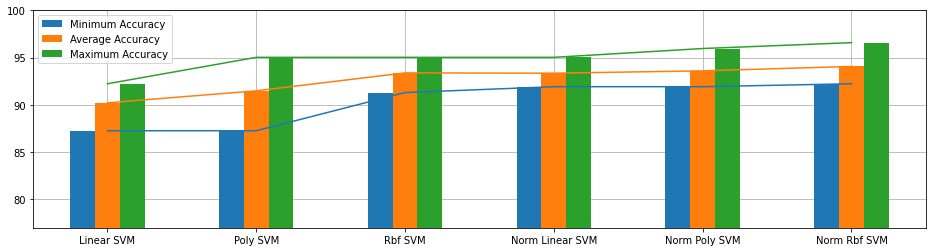

In [3]:
svm_bars = pd.DataFrame(
    {
        "Minimum Accuracy": min_accuracy,
        "Average Accuracy": avg_accuracy,
        "Maximum Accuracy": max_accuracy,
    },
    index=index
)

ax = svm_bars.plot.bar(rot=0, figsize=(16, 4))
ax.set_ylim(int(lowest_min_accuracy - 10) , 100)
ax.grid(True)
ax.set_axisbelow(True)
ax.plot(svm_bars)

As we can see, angular kernels tend to perform better on average. However, let us take the kernel that obtained the best average precision to compare it with the other classifiers

In [4]:
result = svm_table.iloc[-1]

minimum_accuracy = [
    round(result['Minimum Accuracy'], 4),
    round(knn_score.min() * 100, 4) ,
    round(naive_bayes_score.min_accuracy * 100) 
]
for acc in minimum_accuracy:
    lowest_min_accuracy = acc if lowest_min_accuracy > acc else lowest_min_accuracy
average_accuracy = [
    round(result['Average Accuracy']),
    round(knn_score.mean() * 100, 4) ,
    round(naive_bayes_score.avg_accuracy * 100, 4)
]
maximum_accuracy = [
    round(result['Maximum Accuracy']),
    round(knn_score.max() * 100, 4) ,
    round(naive_bayes_score.max_accuracy * 100, 4) 
]
elapsed_time = [
    result['Elapsed time'],
    knn_time,
    naive_bayes_time
]
var_of_accuracy = [
    result['Variance of Accuracy'],
    knn_score.var(),
    naive_bayes_score.accuracy_variance
]
std_of_accuracy = [
    result['Standard deviation of Accuracy'],
    knn_score.std(),
    sqrt(naive_bayes_score.accuracy_variance)
]
index = [
    result.name,
    "K-NN",
    "Naive Bayes"
]
df_for_table = pd.DataFrame(
    {
        "Minimum Accuracy": minimum_accuracy,
        "Average Accuracy": average_accuracy,
        "Maximum Accuracy": maximum_accuracy,
        "Variance of Accuracy": var_of_accuracy,
        "Standard deviation of Accuracy": std_of_accuracy,
        "Elapsed time": elapsed_time,
    },
    index=index
)

df_for_table.sort_values(by=['Average Accuracy'])

,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Variance of Accuracy,Standard deviation of Accuracy,Elapsed time
Naive Bayes,81.0000,85.2320,87.3638,0.003425,0.058523,0.044981
K-NN,89.3478,90.8931,92.1739,0.000087,0.009310,0.061748
Norm Rbf SVM,92.2360,94.0000,97.0000,0.000194,0.013920,4.279000


And finally, we plot the dataframe:

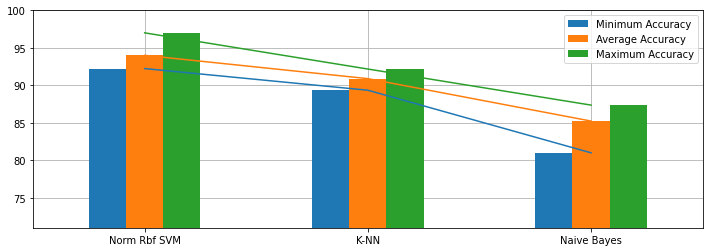

In [5]:
df = pd.DataFrame(
    {
        "Minimum Accuracy": minimum_accuracy,
        "Average Accuracy": average_accuracy,
        "Maximum Accuracy": maximum_accuracy,
    },
    index=index
)

ax = df.plot.bar(rot=0, figsize=(12, 4))
# ax.grid(True, )
ax.set_ylim(int(lowest_min_accuracy) - 10, 100)

# import matplotlib as plt
ax.grid(True)
ax.set_axisbelow(True)
ax.plot(df)



Clearly, the SVM classifier outperforms all classifiers in terms of accuracy.